$f_{0}$ extraction using the Pitch Tracking Dataset from TU Graz (PTDBUG)

At first, import packages to be used for the experiments

In [1]:
import os
import glob
import numpy as np
from tqdm import tqdm
import time

from sklearn.base import clone
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, zero_one_loss
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.manifold import TSNE
from joblib import Parallel, delayed, dump, load
from pyrcn.echo_state_network import ESNRegressor
import matplotlib
from matplotlib import pyplot as plt
#Options
params = {'image.cmap' : 'jet',
          'text.usetex' : True,
          'font.size' : 11,
          'axes.titlesize' : 24,
          'axes.labelsize' : 20,
          'lines.linewidth' : 3,
          'lines.markersize' : 10,
          'xtick.labelsize' : 16,
          'ytick.labelsize' : 16,
          'text.latex.unicode': True,
          }
plt.rcParams.update(params) 
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import librosa

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


Print number of files that are included in the dataset

In [2]:
training_files = np.loadtxt(r"Z:\Projekt-Pitch-Datenbank\SPEECH_DATA\SPEECH_DATAsplit\training.txt", dtype=str)
validation_files = np.loadtxt(r"Z:\Projekt-Pitch-Datenbank\SPEECH_DATA\SPEECH_DATAsplit\validation.txt", dtype=str)
test_files = np.loadtxt(r"Z:\Projekt-Pitch-Datenbank\SPEECH_DATA\SPEECH_DATAsplit\test.txt", dtype=str)
print("{0}\t{1}\t{2}".format(len(training_files), len(validation_files), len(test_files)))

3198	576	944


Feature visualization

Z:\Projekt-Pitch-Datenbank\SPEECH_DATA\SPEECH_DATA\FEMALE\MIC\F01\mic_F01_si569.wav
48000
(638, 1025)


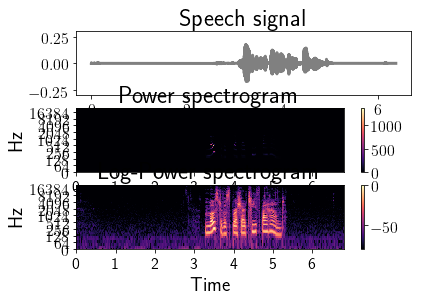

In [3]:
# Load the audio signal and normalize it.
print(training_files[0])
x, sr = librosa.core.load(training_files[0], sr=None, mono=False)
stft_frames = np.abs(librosa.stft(x, n_fft=2048, hop_length=int(0.01*sr), win_length=int(0.04*sr)))**2
S = librosa.power_to_db(stft_frames, ref=np.max)
X = S.T
print(sr)
print(X.shape)
# Define time axis in seconds
t = np.arange(len(x)) / sr
plt.subplot(3, 1, 1)
plt.plot(t, x, color='gray')
# plt.xlabel('Time (seconds)')
# plt.ylabel('Amplitude')
plt.ylim([-0.3, 0.3])
plt.title("Speech signal")
plt.subplot(3, 1, 2)
librosa.display.specshow(stft_frames, sr=sr, y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(S, sr=sr, y_axis='log', x_axis='time')
plt.title('Log-Power spectrogram')
plt.colorbar()

Helper function for feature extraction

In [4]:
def extract_features(file_name):
    x, sr = librosa.core.load(file_name, sr=None, mono=False)
    stft_frames = np.abs(librosa.stft(x, n_fft=2048, hop_length=int(0.01*sr), win_length=int(0.04*sr)))**2
    S = librosa.power_to_db(stft_frames, ref=np.max)
    X = S.T
    y = np.zeros(shape=(S.T.shape[0], 2))
    txt_data = np.loadtxt(file_name.replace("MIC", "REF").replace("mic", "ref").replace(".wav", ".f0"), usecols=(0, 1))
    y[2:2+len(txt_data), :] = txt_data
    return X, y

# Prepare a scaler to standardize features

In [5]:
scaler = StandardScaler()
print("extracting features from the training set...")
with tqdm(total=len(training_files)) as pbar:
    for k, file_name in enumerate(training_files):
        X, y = extract_features(file_name)
        scaler.partial_fit(X=X)
        pbar.update(1)
print("done!")
dump(scaler, "scaler.joblib")

extracting features from the training set...


100%|██████████████████████████████████████████████████████████████████████████████| 3198/3198 [18:41<00:00,  3.23it/s]


done!


['scaler.joblib']

Feature visualization

Z:\Projekt-Pitch-Datenbank\SPEECH_DATA\SPEECH_DATA\FEMALE\MIC\F01\mic_F01_si569.wav
48000
(638, 1025)


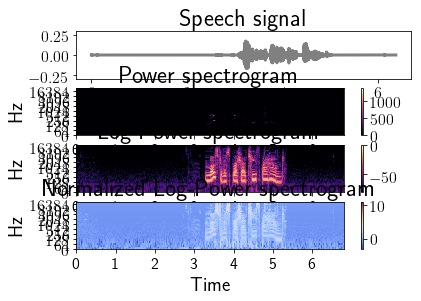

In [6]:
# Load the audio signal and normalize it.
print(training_files[0])
x, sr = librosa.core.load(training_files[0], sr=None, mono=False)
stft_frames = np.abs(librosa.stft(x, n_fft=2048, hop_length=int(0.01*sr), win_length=int(0.04*sr)))**2
S = librosa.power_to_db(stft_frames, ref=np.max)
X, y = extract_features(training_files[0])
print(sr)
print(X.shape)
# Define time axis in seconds
t = np.arange(len(x)) / sr
plt.subplot(4, 1, 1)
plt.plot(t, x, color='gray')
# plt.xlabel('Time (seconds)')
# plt.ylabel('Amplitude')
plt.ylim([-0.3, 0.3])
plt.title("Speech signal")
plt.subplot(4, 1, 2)
librosa.display.specshow(stft_frames, sr=sr, y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar()
plt.subplot(4, 1, 3)
librosa.display.specshow(S, sr=sr, y_axis='log', x_axis='time')
plt.title('Log-Power spectrogram')
plt.colorbar()
plt.subplot(4, 1, 4)
librosa.display.specshow(scaler.fit_transform(X).T, sr=sr, y_axis='log', x_axis='time')
plt.title('Normalized Log-Power spectrogram')
plt.colorbar()

Define several error functions for $f_{0}$ extraction

In [7]:
def gpe(y_true, y_pred):
    """
    Gross pitch error:
    
    All frames that are considered voiced by both pitch tracker and ground truth, 
    for which the relative pitch error is higher than a certain threshold (\SI{20}{\percent}).
    
    """
    idx = np.nonzero(y_true*y_pred)[0]
    return np.mean(np.abs(y_true[idx] - y_pred[idx]) > 0.2 * y_true[idx])


def vde(y_true, y_pred):
    """
    Voicing Decision Error:
    
    Proportion of frames for which an incorrect voiced/unvoiced decision is made.
    
    """
    return zero_one_loss(y_true, y_pred)


def fpe(y_true, y_pred):
    """
    Fine Pitch Error:
    
    Standard deviation of the distribution of relative error values (in cents) from the frames
    that do not have gross pitch errors
    """
    idx_voiced = np.nonzero(y_true * y_pred)[0]
    idx_correct = np.argwhere(np.abs(y_true - y_pred) <= 0.2 * y_true).ravel()
    idx = np.intersect1d(idx_voiced, idx_correct)
    return 100 * np.std(np.log2(y_pred[idx] / y_true[idx]))


def ffe(y_true, y_pred):
    """
    $f_{0}$ Frame Error:
    
    Proportion of frames for which an error (either according to the GPE or the VDE criterion) is made.
    FFE can be seen as a single measure for assessing the overall performance of a pitch tracker.
    """
    idx_correct = np.argwhere(np.abs(y_true - y_pred) <= 0.2 * y_true).ravel()
    return 1 - len(idx_correct) / len(y_true)

Initialize an Echo State Network

In [8]:
base_esn = ESNRegressor(k_in=10, input_scaling=0.1, spectral_radius=0.0, bias=0.0, leakage=1.0, reservoir_size=500,
                        k_res=10, reservoir_activation='tanh', teacher_scaling=1.0, teacher_shift=0.0,
                        bi_directional=False, solver='ridge', beta=1e-3, random_state=0)

Define a helper function to optimize hyper-parameters

In [9]:
def loss_function(base_esn, params, scaler, training_files, validation_files):
    esn = clone(base_esn).set_params(**params)
    for k, file_name in enumerate(training_files):
        X, y = extract_features(file_name)
        X = scaler.fit_transform(X)
        esn.partial_fit(X=X, y=y, update_output_weights=False)
    esn.finalize()
    ffe_training = [None] * len(training_files)
    for k, file_name in enumerate(training_files):
        X, y = extract_features(file_name)
        X = scaler.fit_transform(X)
        y_pred = esn.predict(X=X)
        ffe_training[k] = ffe(y_true=y[:, 0]*y[:, 1], y_pred=y_pred[:, 0]*(y_pred[:, 1] >= .5))
    ffe_validation = [None] * len(validation_files)
    for k, file_name in enumerate(validation_files):
        X, y = extract_features(file_name)
        X = scaler.fit_transform(X)
        y_pred = esn.predict(X=X)
        ffe_validation[k] = ffe(y_true=y[:, 0]*y[:, 1], y_pred=y_pred[:, 0]*(y_pred[:, 1] >= .5))
    return [np.mean(ffe_training), np.mean(ffe_validation)]

Optimize input scaling

In [ ]:
grid = {'input_scaling': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]}
losses = Parallel(n_jobs=-1, verbose=50)(delayed(loss_function)(base_esn, params, scaler, training_files, validation_files) for params in ParameterGrid(grid))

losses = np.asarray(losses)

print("The lowest training FFE: {0}; parameter combination: {1}".format(np.min(losses[:, 0]), ParameterGrid(grid)[np.argmin(losses[:, 0])]))
print("The lowest validation FFE: {0}; parameter combination: {1}".format(np.min(losses[:, 1]), ParameterGrid(grid)[np.argmin(losses[:, 1])]))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
